# Stroke Prediction

# 1. Prepare Problem

## a) Load libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import export_text
from pickle import dump, load
from imblearn.over_sampling import SVMSMOTE

pd.set_option('display.width', 1000)
pd.set_option('precision', 3)

## b) Load dataset

In [2]:
filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']   #
target = 'stroke'

# 2. Summarize Data

## a) Descriptive statistics

### View few first rows

In [212]:
data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1


### Dimensions of data

In [3]:
data.shape

(5110, 11)

### Data type of each attribute

In [4]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### Statistical summary

In [5]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,43.227,0.097,0.054,106.148,28.893,0.049
std,22.613,0.297,0.226,45.284,7.854,0.215
min,0.080,0.000,0.000,55.120,10.300,0.000
25%,25.000,0.000,0.000,77.245,23.500,0.000
50%,45.000,0.000,0.000,91.885,28.100,0.000
75%,61.000,0.000,0.000,114.090,33.100,0.000
max,82.000,1.000,1.000,271.740,97.600,1.000


### Class distribution

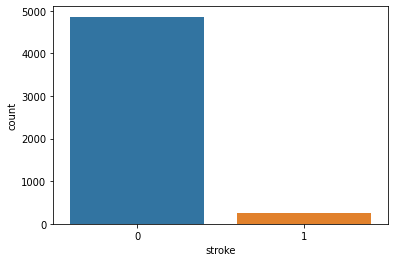

In [20]:
seaborn.countplot(x='stroke', data=data)
pyplot.savefig("class_distribution.png")
pyplot.show()

In [11]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Our dataset is severely imbalanced.

### Identify Columns That Have Very Few Values

In [7]:
n_uniques = data.nunique()
print("Number of unique values in each columns")
print("{:<20}{:>8}{:>12}\t {}".format("Column", "n_unique", "Percentage", "Unique values"))
print("-----------------------------------------------------------------------------------------")
for col in data.columns:
    percentage = n_uniques[col] / data.shape[0] * 100
    print("{:<20}{:>8}{:>12.1f}%\t".format(col, n_uniques[col], percentage), (data[col].unique() if percentage < 1 else ""))

Number of unique values in each columns
Column              n_unique  Percentage	 Unique values
-----------------------------------------------------------------------------------------
gender                     2         0.0%	 ['Male' 'Female']
age                      104         2.0%	 
hypertension               2         0.0%	 [0 1]
heart_disease              2         0.0%	 [1 0]
ever_married               2         0.0%	 ['Yes' 'No']
work_type                  5         0.1%	 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type             2         0.0%	 ['Urban' 'Rural']
avg_glucose_level       3978        77.9%	 
bmi                      418         8.2%	 
smoking_status             4         0.1%	 ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke                     2         0.0%	 [1 0]


Luckily, we don't have any single-value columns.

Downhere, we'll mark columns which have number of unique values less than 1% of total number of observations as categorical.

### Determine Numerical and Categorical Features

In [3]:
data = data[data['gender'] != "Other"]
# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique()
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("Categorical:", categorical_ix)
print("Numerical:", numerical_ix)

Categorical: ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']
Numerical: ['age', 'avg_glucose_level', 'bmi']


## b) Data visualizations

### Univariate Plots

The skew result show a positive (right) or negative (left) skew. Values closer to zero show
less skew.

#### Histograms

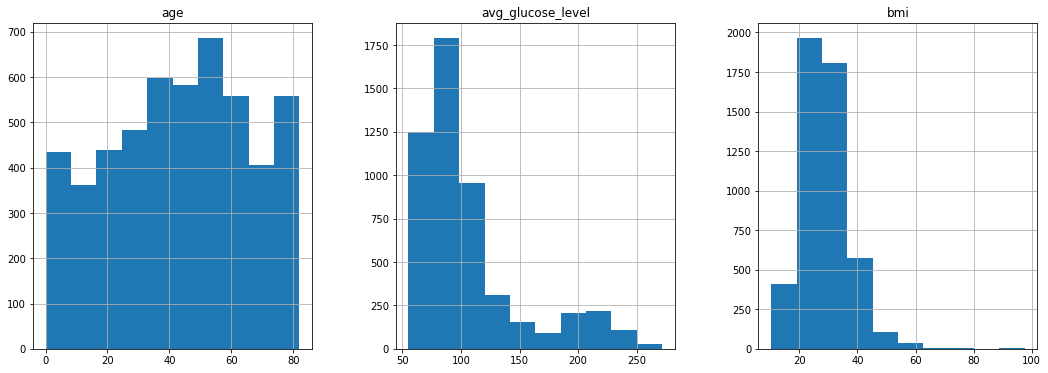

In [17]:
data[numerical_ix].hist(figsize=(18, 6), layout=(1, 3))
pyplot.show()

#### Density Plots

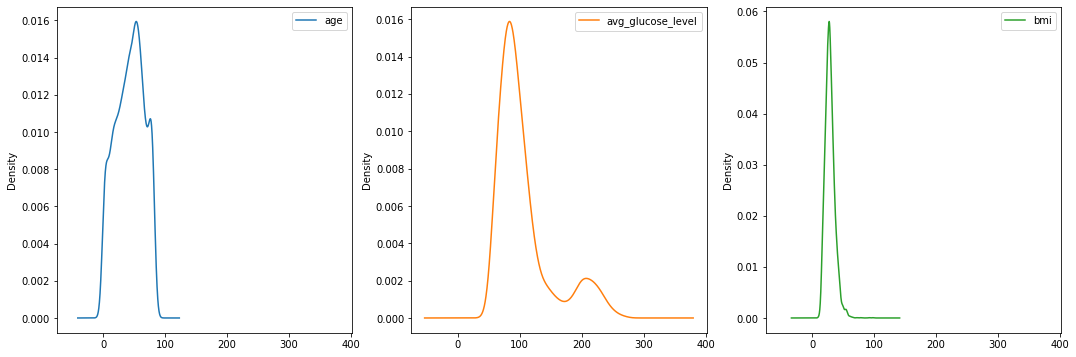

In [20]:
data[numerical_ix].plot(kind='density', subplots=True, layout=(1,3), figsize=(18, 6))
pyplot.show()

#### Box and Whisker Plots

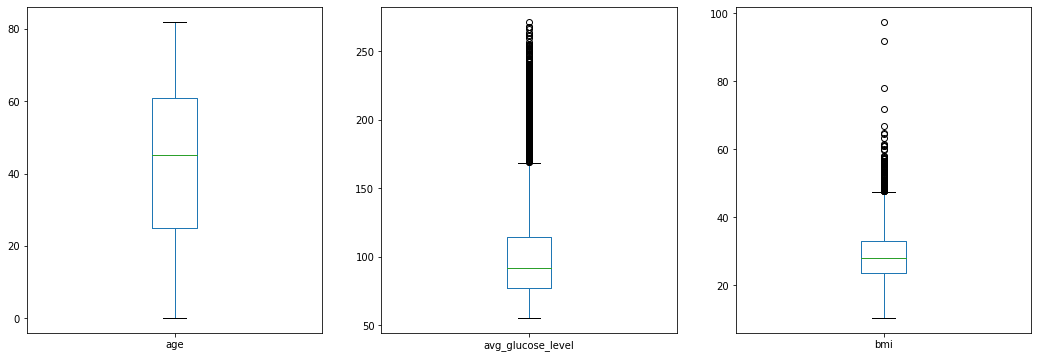

In [19]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.savefig("boxplot_before.png")
pyplot.show()

#### Pie Plots

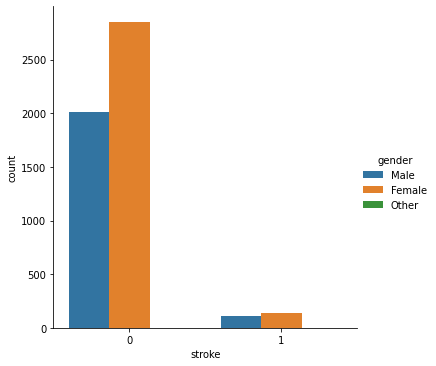

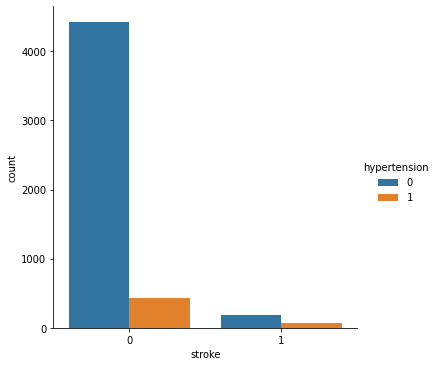

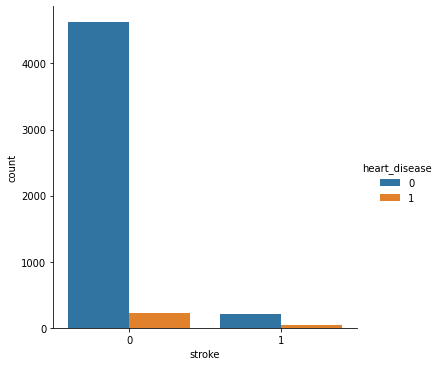

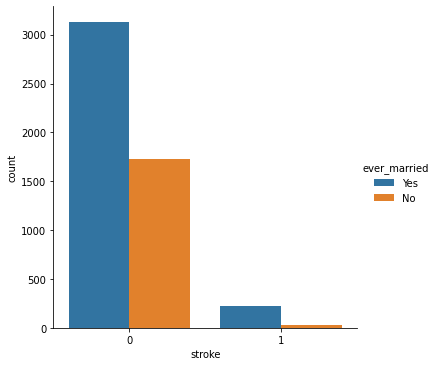

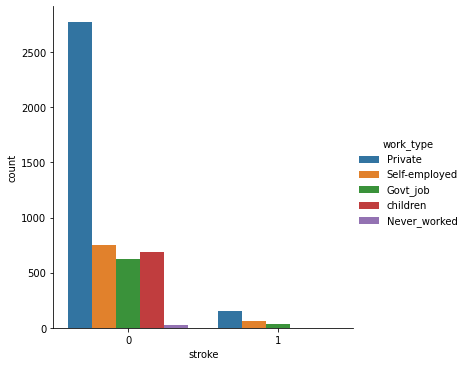

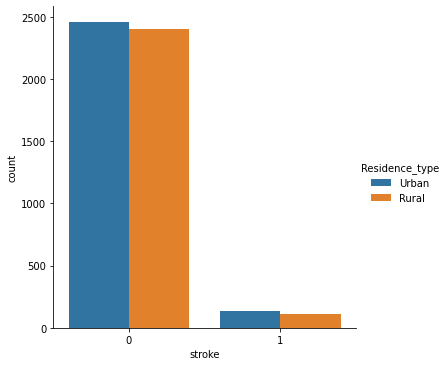

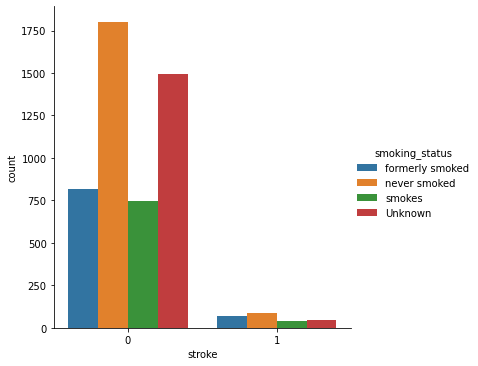

In [59]:
for col in categorical_ix:
    seaborn.catplot(x='stroke', kind='count', data=data, hue=col)

### Multivariate Plots

#### Correlation Matrix Plot

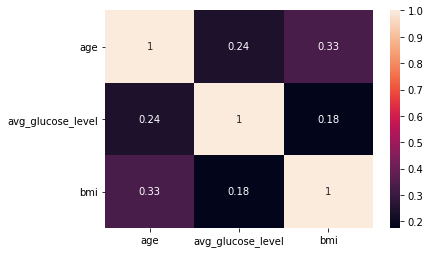

In [69]:
correlations = data[numerical_ix].corr(method='pearson')
seaborn.heatmap(correlations, annot=True)
pyplot.show()

#### Pair Plots

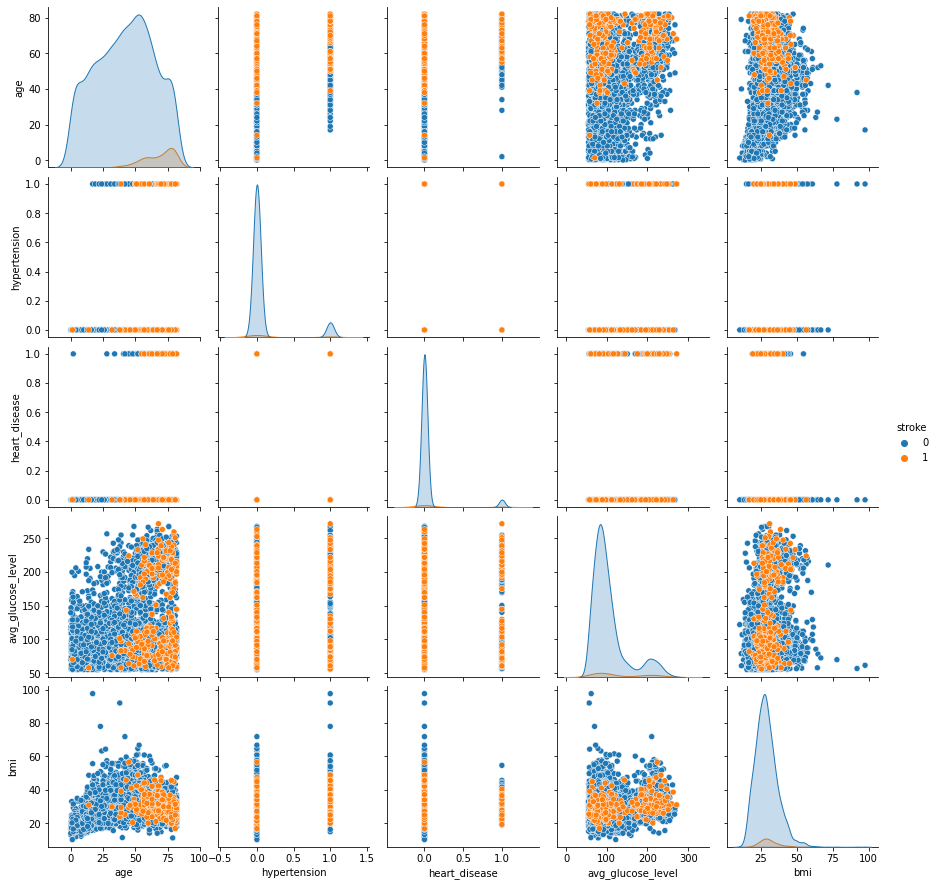

In [21]:
seaborn.pairplot(data.sort_values('stroke'), hue='stroke')
pyplot.savefig("pairplot.png")
pyplot.show()

prompt a lot of questions, assumptions and hypotheses

# 3. Prepare Data

## a) Data Cleaning

### Remove Rows That Contain Duplicate Data

In [4]:
print(data.shape[0])
dups = data.duplicated()
n_dups = len(data[dups])
data.drop_duplicates(inplace=True)
print(data.shape[0])

		Number of rows
-------------------------------
Before		5109
Duplicated	0
After		5109



### Outliers Removal On Numerical Features

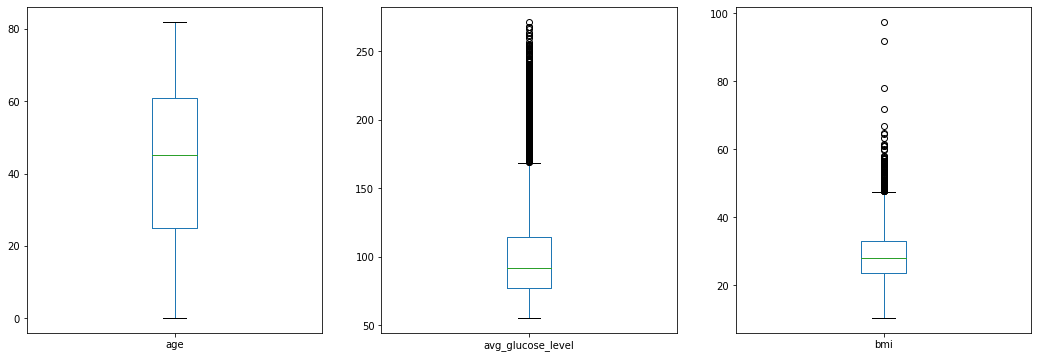

,age,avg_glucose_level,bmi
count,5109.000,5109.000,4908.000
mean,43.230,106.140,28.895
std,22.614,45.285,7.854
min,0.080,55.120,10.300
25%,25.000,77.240,23.500
50%,45.000,91.880,28.100
75%,61.000,114.090,33.100
max,82.000,271.740,97.600


In [9]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.show()

data[numerical_ix].describe()

By looking at the table, box plot and by research domain specific knowledge, we infer:

* *age* feature has outliers, where min value should be greater than or equal to 1
* *bmi* feature has outliers, where max value should not be far greater than 70


#### Option 1: Outlier Detection By Standard Deviation Method

From histogram, we assume *bmi* have near-Gaussian distribution. So we can apply Standard Deviation method in defining outliers.

Factor 4 of standard deviation from mean seems to be a reasonable boundary with *bmi* values.

In [ ]:
outlier_strategy = 'Standard_Deviation_Outlier_Detection'
bmi_mean, bmi_std = data["bmi"].mean(), data["bmi"].std()
factor = 4
cut_off = bmi_std * factor
bmi_upper = bmi_mean + cut_off
age_lower = 1

#### Option 2: Outlier Detection By Quantile Range

Factor 4 of IQR from quantile 75th seems to be a reasonable boundary with *bmi* values.

In [4]:
outlier_strategy = 'Quantile_Range_Outlier_Detection'
q25, q75 = data['bmi'].quantile(0.25), data['bmi'].quantile(0.75)
iqr = q75 - q25
factor = 4
cut_off = iqr * factor
bmi_upper = q75 + cut_off
age_lower = 1

#### View Outliers

Quantile_Range_Outlier_Detection
UPPER BOUND FOR BMI IS NOW: 71.5
LOWER BOUND FOR AGE IS NOW: 1
> NUMBER OF OUTLIERS DETECTED: 47


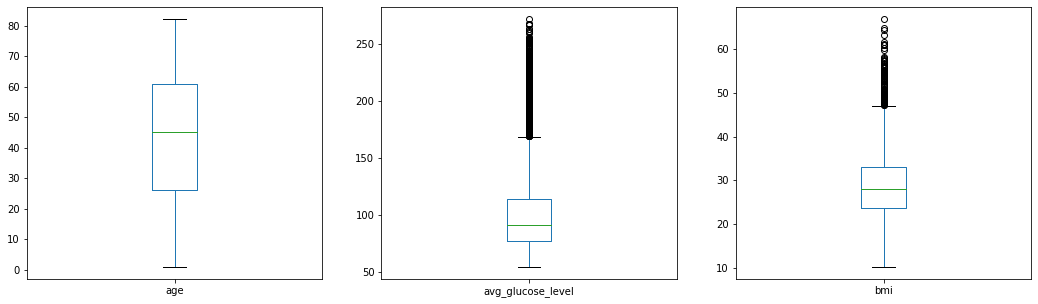

> THESE ARE OUTLIERS:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
7559,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0
22706,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0
545,Male,42.00,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
61511,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
41097,Female,23.00,1,0,No,Private,Urban,70.03,78.0,smokes,0
54747,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
53279,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
66772,Female,0.32,0,0,No,children,Rural,55.86,16.0,Unknown,0
68908,Female,0.72,0,0,No,children,Urban,66.36,23.0,Unknown,0


In [5]:
print(outlier_strategy)
print("UPPER BOUND FOR BMI IS NOW:", bmi_upper)
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
mask_outlier = (data["bmi"] > bmi_upper) | (data["age"] < age_lower)
mask_nonoutlier = mask_outlier == False

print("> NUMBER OF OUTLIERS DETECTED:", data[mask_outlier].shape[0])

# box and whisker plot
data[mask_nonoutlier][numerical_ix].plot(kind='box', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.show()

print("> THESE ARE OUTLIERS:")
data[mask_outlier]

#### Remove Detected Outliers On The Entire Data Set

In [6]:
data = data[mask_nonoutlier].copy()

### Impute Missing Values

In [ ]:
for col in data.columns:
    n_miss = data[col].isnull().sum()
    perc = n_miss/data.shape[0] * 100
    print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

> gender                       0            0.0%
> age                          0            0.0%
> hypertension                 0            0.0%
> heart_disease                0            0.0%
> ever_married                 0            0.0%
> work_type                    0            0.0%
> Residence_type               0            0.0%
> avg_glucose_level            0            0.0%
> bmi                        201            3.9%
> smoking_status               0            0.0%
> stroke                       0            0.0%


Looking at the above table and unique values of each column, we could tell *bmi* has 201 missing values.


Later on, we'll use `SimpleImputer` in Scikit-learn to replace missing values in *bmi* with its mean


## b) Data Transforms

Downhere, we'll select strategy for data transformation

#### With Numerical Features

* Option: Discretize. This can be done by using `KBinsDiscretizer` from Scikit-learn. We'll test its impact on Decision Tree performance.
> As far as we know, *age* and *bmi* can be separated into 4 groups each:
>* *age*:
>>* Under 14: Children
>>* 15-24: Youth
>>* 25-64: Adults
>>* 65 and over: Senior
>* *bmi*:
>>* Below 18.5: Underweight
>>* 18.5 – 24.9:	Norma
>>* 25.0 – 29.9:	Overweight
>>* 30.0 and Above: Obese
>
> In addition, blood sugar levels can also be split into 4 group, though normal sugar level depends on each specific age group:
>>* Fasting
>>* Before meal
>>* 1-2 hours after eating
>?* Bedtime

#### Encode Categorial Features

* Option 1: Convert to ordinal data
* Option 2: Convert to nominal data

From the name and unique values of each categorical feature listed above, it's intuitive to label all of them as nominal, but we'll try treating them as ordinal for some kind of experiments later on.

In [7]:
# Box plots
def my_boxplot(data, labels, xlabel, ylabel):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    pyplot.boxplot(data)
    ax.set_xticklabels(labels)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.savefig(xlabel + ".png")
    pyplot.show()


def my_lineplot(x, y1, y2, label1, label2, xlabel, ylabel, title):
    line1 = pyplot.plot(x, y1, '-o', label=label1)
    line2 = pyplot.plot(x, y2, '-o', label=label2)
    pyplot.legend()
    pyplot.ylabel(ylabel)
    pyplot.xlabel(xlabel)
    pyplot.savefig(title + ".png")
    pyplot.show()

# 4. Evaluate Algorithms

## a) Split-out Train Set And Test Set

In [8]:
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'])

## b) Test options and evaluation metric

We will use repeated stratified 10-fold cross validation to estimate F1 score.

We'll not use `accuracy` as evaluation metric because it is only suitable when there are an equal number of observations in each class. However, that's not the case in our problem.

In [9]:
num_folds = 5
scoring = 'f1'

## c) SMOTE's effect on CART model's performance

Let's see how SMOTE oversamples our dataset with ratio 0.4, i.e
$$\frac{\# \text{not_stroke}}{\# \text{stroke}} = \frac{4}{10}$$

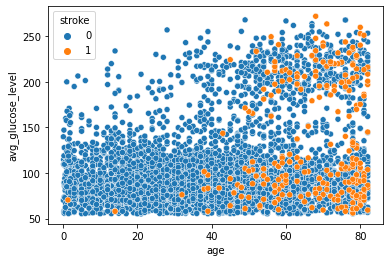

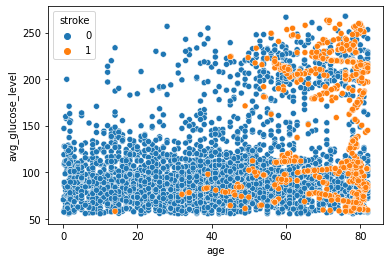

In [25]:
# Before SMOTE
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

seaborn.scatterplot(data=data.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke')
pyplot.savefig("before_SMOTE.png")
pyplot.show()

# After SMOTE
smote = Pipeline([('Trans', transformer),
                  ('SMOTE', SVMSMOTE(sampling_strategy=0.4))])
X_over, Y_over = smote.fit_resample(X_train, Y_train)
data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
data_over['stroke'] = Y_over
seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke')
pyplot.savefig("after_SMOTE.png")
pyplot.show()

Let's try different ratios for SMOTE to see how it affects our CART model's performance.

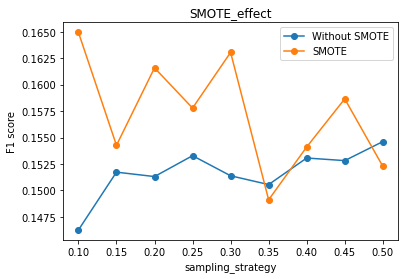

In [28]:
ratios = np.arange(0.1, 0.51, 0.05)
sum_imb_scores = [0] * len(ratios)
sum_smote_scores = [0] * len(ratios)
iter_nums = 5

transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

for _ in range(iter_nums):
    for i in range(len(ratios)):
        imb_model = Pipeline([('Trans', transformer),
                              ('CART', DecisionTreeClassifier())])
        smote_model = Pipeline([('Trans', transformer),
                                ('SMOTE', SVMSMOTE(sampling_strategy=ratios[i])),
                                ('CART', DecisionTreeClassifier())])
        kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)

        imb_results = cross_val_score(imb_model, X_train, Y_train, cv=kfold, scoring=scoring)
        sum_imb_scores[i] += imb_results.mean()

        smote_results = cross_val_score(smote_model, X_train, Y_train, cv=kfold, scoring=scoring)
        sum_smote_scores[i] += smote_results.mean()

avg_imb_scores = [i/iter_nums for i in sum_imb_scores]
avg_smote_scores = [i/iter_nums for i in sum_smote_scores]

# Line plots
my_lineplot(x=ratios, y1=avg_imb_scores, y2=avg_smote_scores, label1='Without SMOTE', label2='SMOTE', xlabel='sampling_strategy', ylabel='F1 score', title="SMOTE_effect")

The line plot suggests that SMOTE helps increase the performance of CART model. Later on, we'll choose 0.3 as the SMOTE `sampling_strategy` in the rest of our project.

## d) Different encoding strategies' effect on CART model's performance


Ordinal: 0.163695 (0.065535)
... with: n_leaves: 268 	depth: 17
OneHot: 0.148802 (0.048512)
... with: n_leaves: 289 	depth: 18


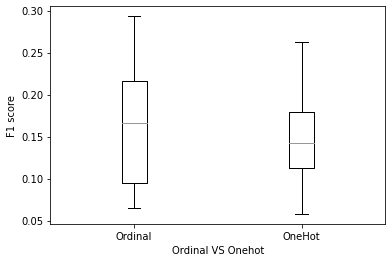

In [12]:
transformers = [('Ordinal', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                               ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                              remainder='passthrough')),
                ('OneHot', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                              ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                             remainder='passthrough'))
                ]
results = []
names = []
models = []

for name, transformer in transformers:
    model = Pipeline([('Trans', transformer),
                      ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                      ('CART', DecisionTreeClassifier())])
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

    model.fit(X_train, Y_train)
    models.append(model)
    print("... with: n_leaves: %d \tdepth: %d" % (model['CART'].get_n_leaves(), model['CART'].get_depth()))
    # tree.plot_tree(model['CART'])
    pyplot.show()

my_boxplot(xlabel='Ordinal VS Onehot', data=results, labels=names, ylabel="F1 score")

Normally, we would expect one-hot encoding to improve the model because all of our categorical features are norminal, not ordinal.

But as the results suggests, one-hot encoding perform slightly worse than the model with ordinal encoding

According to some article, one explanation for this might relate to feature importance.....

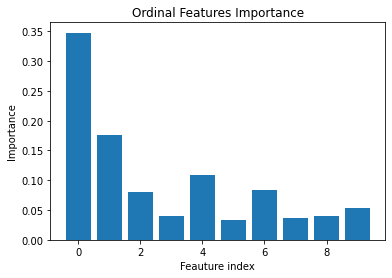

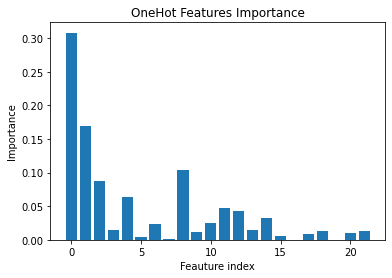

In [110]:
fig, ax = pyplot.subplots()
for name, model in zip(names, models):
    pyplot.title(name + " Features Importance")
    pyplot.xlabel('Feauture index')
    pyplot.ylabel('Importance')
    imps = model['CART'].feature_importances_
    pyplot.bar(range(len(imps)), imps)
    pyplot.show()

In the figure above, ...

## e) Discretization's effect on CART model's performance

Decision Tree prefers categorical variables. So, it's desirable to transform numerical variables to have discrete probability distribution where each value is assigned a label and have an ordinal relationship

NoDiscretizer: 0.157155 (0.043969)
... with: n_leaves: 267 	depth: 20
2Bins: 0.074633 (0.049207)
... with: n_leaves: 334 	depth: 18
3Bins: 0.123921 (0.058143)
... with: n_leaves: 413 	depth: 20
4Bins: 0.099823 (0.051508)
... with: n_leaves: 465 	depth: 21


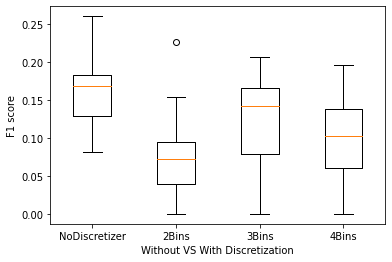

In [13]:
transformers = [('NoDiscretizer', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                                               ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                                              remainder='passthrough')),
                ('2Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                                       remainder='passthrough')),
                ('3Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                                       remainder='passthrough')),
                ('4Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                                       remainder='passthrough'))

                ]
results = []
names = []
for name, transformer in transformers:
    model = Pipeline([('Trans', transformer),
                      ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                      ('CART', DecisionTreeClassifier())])
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

    model.fit(X_train, Y_train)
    print("... with: n_leaves: %d \tdepth: %d" % (model['CART'].get_n_leaves(), model['CART'].get_depth()))
    # tree.plot_tree(model['CART'])
    pyplot.show()

my_boxplot(xlabel='Without VS With Discretization', data=results, labels=names, ylabel="F1 score")

Discretization seems to degrade the performance of the model. Why? I don't know, I'm so tired to search for that, may be I'll do it later on. =)))

## e) Algorithm Tuning

```
DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
```

#### `splitter`

According to some articles, decision trees tend to overfit on data with large number of features.

Besides, it can do feature selection automatically by applying (Im)purity measure. This can be done by set parameter `splitter=best`. Another value for `splitter` is `random`. If we have hundreds of features, `best` is more preferred because `random` might result in features that don’t give much information, which would lead to a more deeper, less precise tree.

However, with our Stroke data is small with 10 features, so we might be able to see the difference.

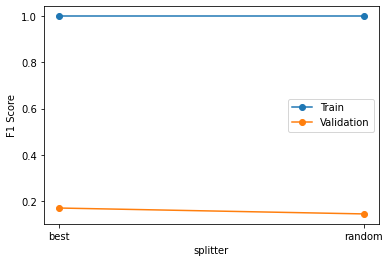

In [114]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

train_results = []
validation_results = []
splitters = ['best', 'random']

for splitter in splitters:
    model = Pipeline([('Trans', transformer),
                      ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                      ('CART', DecisionTreeClassifier(splitter=splitter))])
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=splitters, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='splitter', ylabel='F1 Score')

#### `max_depth`

This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. However, `max_depth` needs controlling to prevent overfitting.

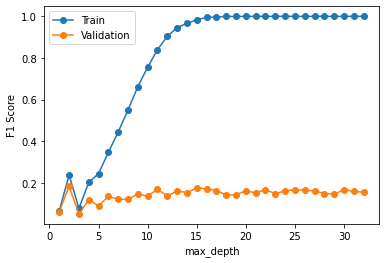

In [220]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

train_results = []
validation_results = []
max_depths = np.arange(1, 33, 1)

for max_depth in max_depths:
    model = Pipeline([('Trans', transformer),
                                 ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                                 ('CART', DecisionTreeClassifier(max_depth=max_depth))])
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=max_depths, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='max_depth', ylabel='F1 Score')

As we can see in the figure, the model predicts fairly well on train set as `max_depth` increases, but fails on new data.


#### `min_samples_split`

The minimum number of samples required to split an internal node. When we increase `min_samples_split`, tree becomes more constrained because it have to consider more examples.

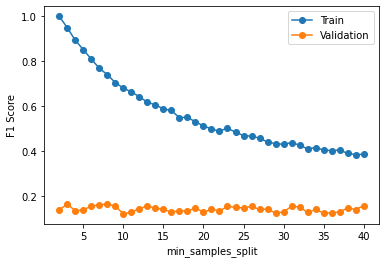

In [116]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

train_results = []
validation_results = []
min_samples_splits = np.arange(2, 41, 1)

for min_samples_split in min_samples_splits:
    model = Pipeline([('Trans', transformer),
                                 ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                                 ('CART', DecisionTreeClassifier(min_samples_split=min_samples_split))])
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=min_samples_splits, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='min_samples_split', ylabel='F1 Score')

#### `min_samples_leaf`

The minimum number of samples required to be at a leaf node. At any depth, regardless of `min_samples_split`, a split point is only be accepted if each of its leaves have at least `min_samples_leaf` samples.

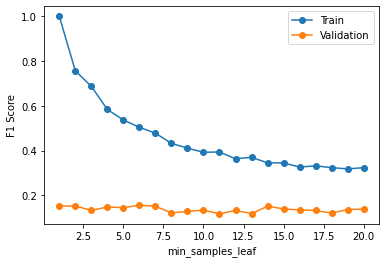

In [117]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

train_results = []
validation_results = []
min_samples_leafs = np.arange(1, 21, 1)

for min_samples_leaf in min_samples_leafs:
    model = Pipeline([('Trans', transformer),
                                 ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                                 ('CART', DecisionTreeClassifier(min_samples_leaf=min_samples_leaf))])
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=min_samples_leafs, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='min_samples_leaf', ylabel='F1 Score')

#### `max_features`

It represents the maximum number of features to consider when looking for the best split.

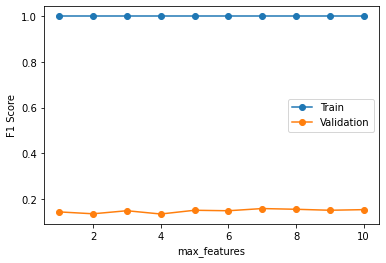

In [301]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

train_results = []
validation_results = []
max_featuress = np.arange(1, 11, 1)

for max_features in max_featuress:
    model = Pipeline([('Trans', transformer),
                                 ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                                 ('CART', DecisionTreeClassifier(max_features=max_features))])
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=max_featuress, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='max_features', ylabel='F1 Score')

#### Try multiple parameters at once

In [ ]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

max_depths = np.arange(15, 22, 1)
min_samples_splits = np.arange(2, 6, 1)
min_samples_leafs = np.arange(1, 6, 1)

param_grid = dict(CART__max_depth=max_depths, CART__min_samples_split=min_samples_splits, CART__min_samples_leaf=min_samples_leafs)
model = Pipeline([('Trans', transformer),
                  ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                  ('CART', DecisionTreeClassifier())])
kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


# 6. Finalizing

## a) Predictions on test set

Base on these above experiments, we'll finalize our CART model as below.

[[1511   93]
 [  61   21]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1604
           1       0.18      0.26      0.21        82

    accuracy                           0.91      1686
   macro avg       0.57      0.60      0.58      1686
weighted avg       0.92      0.91      0.92      1686



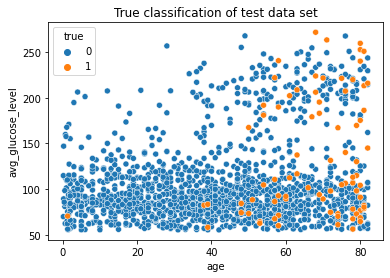

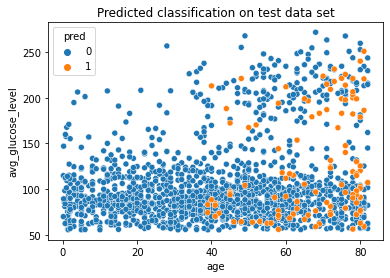

In [239]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

cart = Pipeline([('Trans', transformer),
                  ('SMOTE', SVMSMOTE(sampling_strategy=0.3)),
                  ('CART', DecisionTreeClassifier(max_depth=21))])

# prepare the model
cart.fit(X_train, Y_train)

# estimate on the test dataset
Y_pred = cart.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

data_test = X_test.copy()
data_test['true'] = Y_test
data_test['pred'] = Y_pred
data_test.sort_values('true', inplace=True)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of test data set')
pyplot.show()
data_test.sort_values('pred', inplace=True)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='pred')
pyplot.title('Predicted classification on test data set')
pyplot.show()

## Prediction on the train set

[[3256    0]
 [   0  167]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3256
           1       1.00      1.00      1.00       167

    accuracy                           1.00      3423
   macro avg       1.00      1.00      1.00      3423
weighted avg       1.00      1.00      1.00      3423



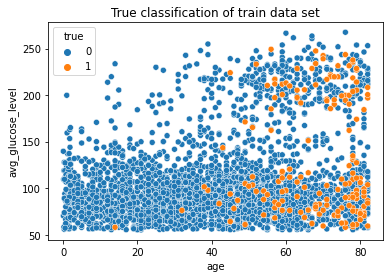

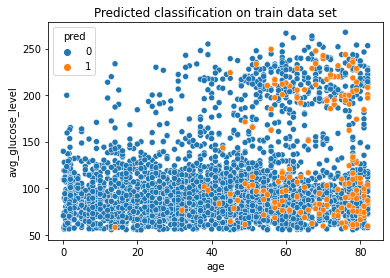

In [242]:
data_train = X_train.copy()
data_train['true'] = Y_train
data_train['pred'] = cart.predict(X_train)
print(confusion_matrix(Y_train, data_train['pred']))
print(classification_report(Y_train, data_train['pred']))
data_train.sort_values('true', inplace=True)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of train data set')
pyplot.show()
data_train.sort_values('pred', inplace=True)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='pred')
pyplot.title('Predicted classification on train data set')
pyplot.show()

We expect recall is as high as possible, because we don't want to mis-label any stroke patients as not stroke when we do prediction.

## c) Save model for later use

Save model

In [240]:
dump(cart, open('cart.pkl', 'wb'))

Load saved model

In [ ]:
model = load(open('cart.pkl', 'rb'))

## d) Visualize Decision Tree

In [ ]:
pyplot.figure(figsize=(250, 250))
tree.plot_tree(cart['CART'], filled=True)
pyplot.savefig('cart_visualize.png')
pyplot.show()

## e) Visualize prediction results

In [ ]:
# Not implemented yet

